# Macro input files


To configure a Macro case, the user needs to provide a set of input files describing at least the following components:
- **System configuration**
- **Assets/technologies**
- **Model settings**


## System configuration

The system configuration files are located in the `system` folder and include the following five files:
- `commodities.json`: describes the commodities flowing through the system.
- `time_data.json`: describes the temporal resolution for each sector in the simulation.
- `nodes.json`: describes the nodes in the system.
- `demand.csv`: describes the demand for each commodity at each node in the system.
- `fuel_prices.csv`: (`supply_data`) describes the fuel prices for each commodity at each node in the system.


#### `commodities.json`
The `commodities.json` file is a JSON file with a list of commodities to include in the case. This is how the file looks like:


In [3]:
s = read("one_zone_electricity_only/system/commodities.json", String)
println(s)

{
    "commodities": [
        "Electricity",
        "NaturalGas",
        "CO2"
    ]
}


To include new commodities, the user just needs to add the new commodity to the list of commodities in the `commodities.json` file.

### `time_data.json`

This file describes the temporal resolution of the simulation. It contains three main parameters:
- `PeriodLength`: total number of hours in the simulation.
- `HoursPerTimeStep`: number of hours in each time step.
- `HoursPerSubperiod`: number of hours in each subperiod. 
Except for the `PeriodLength`, all the other parameters need to be provided for each commodity in the system.
For example, the following is a complete example of the `time_data.json` file:
```json
{
    "PeriodLength": 8760,   // units: hours
    "HoursPerTimeStep": {
        "Electricity": 1,  // units: hours
        "NaturalGas": 1,
        "CO2": 1
    },
    "HoursPerSubperiod": {
        "Electricity": 8760,  // units: hours
        "NaturalGas": 8760,
        "CO2": 8760
    }
}
```
In the example above, the simulation will run for 8760 hours (one year), with one hour per time step and one hour per subperiod for each commodity (single subperiod).

### Units
In Macro, everything that is transformed into electricity is expressed in MWh, and all the other commodities are expressed in metric tons:
- **Time**: hours
- **Electricity**: MWh
- **NaturalGas**: MWh
- **Coal**: MWh
- **Uranium**: MWh
- **Hydrogen**: MWh
- **CO2**: tonnes
- **CO2Captured**: tonnes
- **Biomass**: tonnes

### `nodes.json`

The `nodes.json` file is a JSON file with a list of nodes to include in the case. The file is structured as follows:
1. Each node type (like "NaturalGas") is defined as a dictionary with three main components:
   - `type`: The category of the node (e.g., "NaturalGas")
   - `global_data`: attributes that apply to all instances of this node type
     - `time_interval`: time resolution for the time series in the node (needs to match one of the commodities in the `time_data.json` file)
   - `instance_data`: A list of specific nodes of this type, each with:
     - `id`: A unique identifier for the node
     - `time_interval` (if different from the one in `global_data`): time resolution for the time series in the node (needs to match one of the commodities in the `time_data.json` file)

All other fields (e.g, `demand`, `price`, `constraints`, etc.) are optional and will take the default values if not provided. A complete list of the fields that can be included in the `nodes.json` file can be found in the [Nodes](../src/model/network/node.jl) file.

Here's a simplified example:
```json
"nodes": [
    {
        "type": "NaturalGas",
        "global_data": {
            "time_interval": "NaturalGas"
        },
        "instance_data": [
            {
                "id": "natgas_1",
                "price": {
                    "timeseries": {
                        "path": "system/fuel_prices.csv",
                        "header": "natgas_1"
                    }
                }
            },
            {
                "id": "natgas_2",
                "price": {
                    "timeseries": {
                        "path": "system/fuel_prices.csv",
                        "header": "natgas_2"
                    }
                }
            }
            // ... more instances ...
        ]
    }
]
```

This structure allows you to define multiple nodes of the same type while sharing common settings through `global_data`. 

The following is a slightly more complete example of how to include nodes of type "Electricity", containing the electricity demand at each node in the system:
```json
{
    "type": "Electricity",
    "global_data": {
        "time_interval": "Electricity",
        "constraints": {
            "BalanceConstraint": true,
        }
    },
    "instance_data": [
        {
            "id": "elec_SE",
            "demand": {
                "timeseries": {
                    "path": "system/demand.csv",
                    "header": "Demand_MW_z1"
                }
            }
        },
        {
            "id": "elec_MIDAT",
            "demand": {
                "timeseries": {
                    "path": "system/demand.csv",
                    "header": "Demand_MW_z2"
                }
            }
        },
        {
            "id": "elec_NE",
            "demand": {
                "timeseries": {
                    "path": "system/demand.csv",
                    "header": "Demand_MW_z3"
                }
            }
        }
    ]
}
```

As mentioned before, **Demand** and **price** time series are linked to columns in the `demand` and `fuel_prices` files respectively. The user needs to make sure that the **path** matches the file location and the **header** matches the column name in the file. In the case above, for example, the node `elec_SE` is linked to the column `Demand_MW_z1` in the `demand.csv` file, the node `elec_MIDAT` to the column `Demand_MW_z2`, and the node `elec_NE` to the column `Demand_MW_z3`. 
In particular, the `demand.csv` file has the following structure:


In [4]:
using CSV, DataFrames
demand_data = CSV.read("one_zone_electricity_only/system/demand.csv", DataFrame)
first(demand_data, 10)

Row,Time_Index,Demand_MW_z1
,Int64,Float64
1,1,144712.0
2,2,142292.0
3,3,139757.0
4,4,138274.0
5,5,138001.0
6,6,139207.0
7,7,142098.0
8,8,145214.0
9,9,149789.0


#### Constraints
One of the main features of Macro is the ability to include constraints on the system from a pre-defined library of constraints. To include a constraint to a node, the user needs to add the constraint name to the `constraints` dictionary in the node's `global_data` or `instance_data` field.

For example, to include the `BalanceConstraint` to the node `elec_SE`, the user needs to add the following to the `nodes.json` file:
```json
"constraints": {
    "BalanceConstraint": true
}
```
Another example is the `MaxNonServedDemandConstraint`, which limits the maximum amount of demand that can be unmet in a given time step. To include this constraint to the node `elec_SE`, the user needs to add the following to the `nodes.json` file:
```json
"max_nds": [1],  // units: fraction of the demand
"price_nsd": [5000.0], // units: $/MWh
"constraints": {
    "MaxNonServedDemandConstraint": true,
    "MaxNonServedDemandPerSegmentConstraint": true
}
```
This will add the `MaxNonServedDemandConstraint` and the `MaxNonServedDemandPerSegmentConstraint` to the node `elec_SE` with a maximum non-served demand equal to the demand in each period, and a price of 5000.0 $/MWh for the unmet demand ("max_nds" is the fraction of the demand that can be unmet). 

A complete list of the constraints available in Macro can be found in the [Constraints](../src/model/constraints) folder.

Therefore, a complete example of the `nodes.json` file for the electricity system is the following:
```json
{
    "type": "Electricity",
    "global_data": {
        "time_interval": "Electricity",
        "max_nsd": [
            1   // units: fraction of the demand
        ],
        "price_nsd": [
            5000.0 // units: $/MWh
        ],
        "constraints": {
            "BalanceConstraint": true,
            "MaxNonServedDemandConstraint": true,
            "MaxNonServedDemandPerSegmentConstraint": true
        }
    },
    "instance_data": [
        {
            "id": "elec_SE",
            "demand": {
                "timeseries": {
                    "path": "system/demand.csv",
                    "header": "Demand_MW_z1"
                }
            }
        },
        {
            "id": "elec_MIDAT",
            "demand": {
                "timeseries": {
                    "path": "system/demand.csv",
                    "header": "Demand_MW_z2"
                }
            }
        },
        {
            "id": "elec_NE",
            "demand": {
                "timeseries": {
                    "path": "system/demand.csv",
                    "header": "Demand_MW_z3"
                }
            }
        }
    ]
}
```

#### Time series data
The time series data for the demand and fuel prices are CSV files with the same format:

- First column: time step
- Second column and following: value of the time series for each time step

For example, the `demand.csv` file has the following structure:

In [5]:
# using CSV, DataFrames
demand_data = CSV.read("one_zone_electricity_only/system/demand.csv", DataFrame)
first(demand_data, 10)

Row,Time_Index,Demand_MW_z1
,Int64,Float64
1,1,144712.0
2,2,142292.0
3,3,139757.0
4,4,138274.0
5,5,138001.0
6,6,139207.0
7,7,142098.0
8,8,145214.0
9,9,149789.0


And the `fuel_prices.csv` file has a similar structure:

In [6]:
fuel_prices_data = CSV.read("one_zone_electricity_only/system/fuel_prices.csv", DataFrame)
first(fuel_prices_data, 10)

Row,Time_Index,natgas_SE
,Int64,Float64
1,1,12.5567
2,2,12.5567
3,3,12.5567
4,4,12.5567
5,5,12.5567
6,6,12.5567
7,7,12.5567
8,8,12.5567
9,9,12.5567


where the names of the columns must match the `header` field in the `nodes.json` file for the corresponding node.

The units are `$/MWh` of natural gas.

## Assets/technologies

The assets folder contains all the input files for the assets/resources as well as transmission lines and storage technologies that are included in the system.

Each asset or technology is defined in a separate file, and all files share a similar structure, which closely resembles the structure of the nodes in the `nodes.json` file. Each asset or technology includes the following fields:

- `type`: The type of the asset or technology.
- `global_data`: Attributes that apply universally to all instances of this asset or technology.
- `instance_data`: A list of specific instances of this asset or technology, where each instance contains:
    - `id`: A unique identifier for the asset or technology.

Similarly to the nodes, all the fields defined in the `global_data` will be shared by all the instances of the asset/technology, and the fields defined in `instance_data` can be different for each instance.

**Note:** To understand the structure of the attributes in both `global_data` and `instance_data`, the user can refer to the asset definitions in the [Assets](../src/model/assets) folder. 

To familiarize with the structure of the asset/technology input files, let's now see an example of a **system** with:
- a natural gas power plant, 
- a solar photovoltaic pannel, 
- a wind turbine, 
- a battery.

### Natural gas power plant

#### Type representation
The type that defines the natural gas power plant is `ThermalPower` and can be found in `src/model/assets/thermalpower.jl`. 
Here is a schematic representation of the type:

![ThermalPower](./images/natgas.png)

As expected, a natural gas power plant is made of the followning components:
- **ng → elec transformation**: a transformation object that defines the conversion of the fuel to electricity
- three edges that connect the asset to the rest of the system:
    - **fuel edge**: natural gas input
    - **electricity edge**: electricity output
    - **co2 edge**: CO2 output

Keeping the type representation in mind, we can now see how the asset is defined in the `src/model/assets/thermalpower.jl` file:

```julia
struct ThermalPower{T} <: AbstractAsset
    id::AssetId
    thermal_transform::Transformation
    elec_edge::Union{Edge{Electricity},EdgeWithUC{Electricity}}
    fuel_edge::Edge{T}
    co2_edge::Edge{CO2}
end
```
In the object above, the `id` field is a unique identifier for the asset/technology, and the rest of the fields are the implementation of the transformation and the three edges that we saw before in the type representation.

#### Asset input file

The input file for the natural gas power plant is `one_zone/assets/naturalgas_power.json`. If we open the file, we can notice that, apart from the `id` field, the rest of the fields match the ones we saw in the type representation:
```json
{
    "transforms":{
        // ... thermal_transform fields ...
    },
    "edges":{
        "elec_edge": {
            // ... elec_edge fields ...
        },
        "fuel_edge": {
            // ... fuel_edge fields ...
        },
        "co2_edge": {
            // ... co2_edge fields ...
        }
    }
}
```


Some important attributes for the `transforms` field are:
- `timedata`: time resolution for the time series in the transformation (needs to match one of the commodities in the `time_data.json` file)
- `constraints`: constraints to be applied to the transformation
- `emission_rate`: emission rate of the transformation (MWh of natural gas/Tons of CO2)
- `efficiency_rate`: efficiency rate of the transformation (MWh of electricity/MWh of natural gas)

For the `edges` field, some important attributes are:
- `type`: type of the commodity in the edge
- `start_vertex`: start vertex of the edge
- `end_vertex`: end vertex of the edge
- `unidirectional`: whether the edge is unidirectional or bidirectional
- `has_capacity`: whether the edge can expand during the optimization
- `uc`: whether the edge is a unit commitment variable
- `constraints`: constraints to be applied to the edge
- `investment_cost/fixed_om_cost/variable_om_cost`: investment, fixed, and variable operating costs for the asset
- `existing_capacity`: existing capacity of the asset

The complete list of fields that can be included in each of the fields `transforms`, `elec_edge`, `fuel_edge`, and `co2_edge` can be found in the definition of the `Edge` type in the [Edges](../src/model/network/edge.jl) and `Transformation` type in the [Transformations](../src/model/network/transformations.jl) files.

For example, the following is a complete example of the `naturalgas_power.json` file:

```json
{
    "NaturalGasPower": [
        {
            "type": "ThermalPower",
            "global_data": {
                "transforms": {
                    "timedata": "NaturalGas",
                    "constraints": {
                        "BalanceConstraint": true
                    }
                },
                "edges" : {
                    "elec_edge": {
                        "type": "Electricity",
                        "unidirectional": true,
                        "has_capacity": true,
                        "uc": true,
                        "integer_decisions": false,
                        "constraints": {
                            "CapacityConstraint": true,
                            "RampingLimitConstraint": true,
                            "MinFlowConstraint": true,
                            "MinUpTimeConstraint": true,
                            "MinDownTimeConstraint": true
                        }
                    },
                    "fuel_edge": {
                        "type": "NaturalGas",
                        "unidirectional": true,
                        "has_capacity": false
                    },
                    "co2_edge": {
                        "type": "CO2",
                        "unidirectional": true,
                        "has_capacity": false,
                        "end_vertex": "co2_sink"
                    }
                }
            },
            "instance_data": [
                {
                    "id": "SE_naturalgas_ccavgcf_moderate_0",
                    "transforms":{
                        "emission_rate": 0.181048235160161, // units: MWh of natural gas/Tons of CO2
                        "efficiency_rate": 0.53624731 // units: MWh of electricity/MWh of natural gas
                    },
                    "edges":{
                        "elec_edge": {
                            "end_vertex": "elec_SE",
                            "can_retire": true,
                            "can_expand": true,
                            "existing_capacity": 0.0,
                            "investment_cost": 78218.72932, // units: $/MW/year (annualized)
                            "fixed_om_cost": 27300, // units: $/MW/year (annualized)
                            "variable_om_cost": 1.74, // units: $/MWh
                            "capacity_size": 573, 
                            "startup_cost": 61, // units: $/MW per start
                            "startup_fuel": 0.058614214,  // units: MWh/MW of capacity per start                   
                            "min_up_time": 4, // units: hours
                            "min_down_time": 4, // units: hours
                            "ramp_up_fraction": 1, // units: fraction of the capacity
                            "ramp_down_fraction": 1, // units: fraction of the capacity
                            "min_flow_fraction": 0.3 // units: fraction of the capacity
                        },
                        "fuel_edge": {
                            "start_vertex": "natgas_SE"
                        }
                    }
                }
            ]
        }
    ]
}
```

### Solar photovoltaic pannel and wind turbine
Since the solar photovoltaic pannel and the wind turbine are very similar, the type that defines them is called `Vre` and can be found in `src/model/assets/vre.jl`. 
Here is a schematic representation of the type:

![Vre](./images/solar_pv.png)

As can be seen, a solar photovoltaic pannel and a wind turbine are made of the following components:
- **solar/wind energy → electricity transformation**: a transformation object that defines the conversion of the energy to electricity
- single edge that connects the asset to the rest of the system:
    - **electricity edge**: electricity output

The asset is therefore defined as follows:
```julia
struct VRE <: AbstractAsset
    id::AssetId
    energy_transform::Transformation
    elec_edge::Edge{Electricity}
end
```

The input file for variable renewable resources is `one_zone/assets/solar_pv.json`. If we open the file, we can notice the usual structure for nodes and assets that we should be familiar with by now:
- **type**: type of the asset/technology
- **global_data**: settings that apply to all instances of this asset/technology
- **instance_data**: a list of specific assets/technologies of this type, each with:
    - `id`: a unique identifier for the asset/technology

In the `global_data` and `instance_data` fields, we can notice that we have a `transforms` field that contains the attributes for the `energy_transform` object, and an `edges` field that contains the attributes for the `edge` object that connects the asset to the electricity network:
```json
"transforms": {
    // ... energy_transform fields ...
}
"edges": {
    // ... edge fields ...
}
```

For example, the following is a complete example of the `vre.json` file that defines a solar pv and a wind turbine:
```json
{
    "vre": [
        {
            "type": "VRE",
            "global_data": {
                "transforms": {
                    "timedata": "Electricity"
                },
                "edges": {
                    "elec_edge": {
                        "type": "Electricity",
                        "unidirectional": true,
                        "can_expand": true,
                        "can_retire": false,
                        "has_capacity": true,
                        "constraints": {
                            "CapacityConstraint": true
                        }
                    }
                }
            },
            "instance_data": [
                {
                    "id": "SE_utilitypv_class1_moderate_70_0_2_1",
                    "edges": {
                        "elec_edge": {
                            "fixed_om_cost": 15390.48615,
                            "investment_cost": 49950.17548,
                            "end_vertex": "elec_SE",
                            "availability": {
                                "timeseries": {
                                    "path": "assets/availability.csv",
                                    "header": "SE_utilitypv_class1_moderate_70_0_2_1"
                                }
                            }
                        }
                    }
                },
                {
                    "id": "SE_landbasedwind_class4_moderate_70_1",
                    "edges": {
                        "elec_edge": {
                            "fixed_om_cost": 34568.125,
                            "investment_cost": 68099.00274,
                            "end_vertex": "elec_SE",
                            "availability": {
                                "timeseries": {
                                    "path": "assets/availability.csv",
                                    "header": "SE_landbasedwind_class4_moderate_70_1"
                                }
                            }
                        }
                    },
                }
            ]
        }
    ]
}
```

Something to notice is that the `availability` field is a time series that needs to be provided for each instance of the `VRE`asset. This time series describes the availability of the resource at each time step. This attribute looks very similar to the `demand` field in the nodes input file, where the `path` field is used to link to the time series data in a csv file, and the `header` field is used to match the column name in the file.


This is an example of the `availability.csv` file:

In [7]:
availability_data = CSV.read("one_zone_electricity_only/assets/availability.csv", DataFrame)
first(availability_data, 10)

Row,Time_Index,SE_utilitypv_class1_moderate_70_0_2_1,SE_landbasedwind_class4_moderate_70_1
,Int64,Float64,Float64
1,1,0.0,0.596095
2,2,0.0,0.608125
3,3,0.0,0.60166
4,4,0.0,0.582438
5,5,0.0,0.557827
6,6,0.0,0.532484
7,7,0.00342979,0.52014
8,8,0.187697,0.512936
9,9,0.49936,0.500228


The units are `fraction of installed capacity`.

   Resolving package versions...
      Compat entries added for Plots
    Updating `~/Documents/ZERO_lab/Macro/Macro/Project.toml`
  [91a5bcdd] + Plots v1.40.9
    Updating `~/Documents/ZERO_lab/Macro/Macro/Manifest.toml`
  [e1450e63] - BufferedStreams v1.2.2
  [187b0558] - ConstructionBase v1.5.8
  [e7dc6d0d] - DataValues v0.4.13
  [5789e2e9] - FileIO v1.16.6
  [8fc22ac5] - FilePaths v0.8.3
  [7d188eb4] - JSONSchema v1.4.1
  [2bd173c7] - NodeJS v2.0.0
  [efcf1570] - Setfield v1.1.1
  [382cd787] - TableTraitsUtils v1.0.2
  [30578b45] - URIParser v0.4.1
  [239c3e63] - Vega v2.7.0
  [112f6efa] - VegaLite v3.3.0
Precompiling project...
   1076.6 ms  ✓ Qt6Base_jll
   2293.0 ms  ✓ libass_jll
    937.5 ms  ✓ Qt6ShaderTools_jll
   2024.7 ms  ✓ Pango_jll
   1033.0 ms  ✓ FFMPEG_jll
   1174.2 ms  ✓ Qt6Declarative_jll
    741.1 ms  ✓ FFMPEG
    965.8 ms  ✓ GR_jll
   2322.5 ms  ✓ GR
  32936.2 ms  ✓ Plots
   2974.9 ms  ✓ Plots → UnitfulExt
  11 dependencies successfully precompiled in 44 seconds. 2

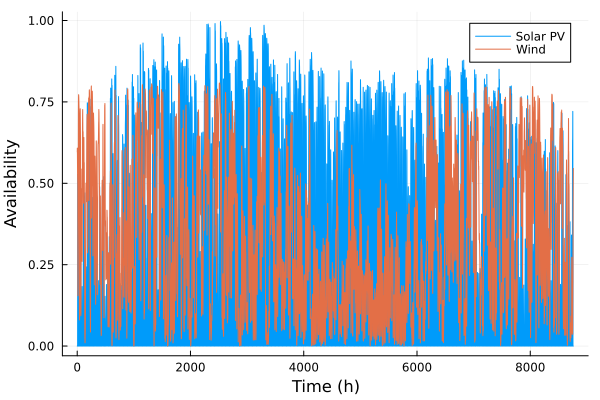

In [8]:
using Pkg; Pkg.add("Plots")
using Plots
p = Plots.plot(availability_data[:,1], availability_data[:,2], label="Solar PV", xlabel="Time (h)", ylabel="Availability")
Plots.plot!(p, availability_data[:,1], availability_data[:,3], label="Wind")

### Battery
Finally, let's see how storage technologies are defined in Macro and how to include them in the system.

A battery is defined by the following components:
- `battery_storage`
- `charge_edge`: a charge edge that connects the battery to the electricity network
- `discharge_edge`: a discharge edge that connects the battery to the electricity network

![Battery](./images/battery.png)

The input file for the battery is `one_zone/assets/battery.json`. Again, if we open the file, we can recognize the usual structure for nodes and assets:
- **type**: type of the asset/technology
- **global_data**: settings that apply to all instances of this asset/technology
- **instance_data**: a list of specific assets/technologies of this type, each with:
    - `id`: a unique identifier for the asset/technology

This is an example of the `battery.json` file:
```json
{
    "elec_stor": [
        {
            "type": "Battery",
            "global_data": {
                "edges": {
                    "discharge_edge": {
                        "type": "Electricity",
                        "unidirectional": true,
                        "has_capacity": true,
                        "can_expand": true,
                        "can_retire": false,
                        "constraints": {
                            "CapacityConstraint": true,
                            "StorageDischargeLimitConstraint": true
                        }
                    },
                    "charge_edge": {
                        "type": "Electricity",
                        "unidirectional": true,
                        "has_capacity": false
                    }
                },
                "storage": {
                    "commodity": "Electricity",
                    "can_expand": true,
                    "can_retire": false,
                    "constraints": {
                        "StorageCapacityConstraint": true,
                        "StorageSymmetricCapacityConstraint": true,
                        "BalanceConstraint": true
                    }
                }
            },
            "instance_data": [
                {
                    "id": "battery_SE",
                    "edges": {
                        "discharge_edge": {
                            "end_vertex": "elec_SE",
                            "existing_capacity" : 0.0,
                            "fixed_om_cost" : 4536.98,
                            "investment_cost": 17239.56121,
                            "variable_om_cost": 0.15,
                            "efficiency": 0.92
                        },
                        "charge_edge": {
                            "start_vertex": "elec_SE",
                            "efficiency": 0.92,
                            "variable_om_cost": 0.15
                        }
                    },
                    "storage":{
                        "existing_capacity_storage": 0.0,
                        "fixed_om_cost_storage": 2541.19, // units: \$/MWh/year (annualized)
                        "investment_cost_storage": 9656.002735, // units: $/MWh/year (annualized)
                        "max_duration": 10, // units: hours
                        "min_duration": 1 // units: hours
                    }
                }
            ]
        }
    ]
}

Something to notice is that both the `edges` and `storage` fields contain a `constraints` field. This is an example of a constraint that can be applied to a battery:
- `StorageCapacityConstraint`: ensures that the capacity of the battery is not exceeded
- `StorageSymmetricCapacityConstraint`: ensures that simultaneous charge and discharge do not exceed the capacity of the battery
- `BalanceConstraint`: ensures that the battery contributes to the demand balance of the system

## Model settings
This folder contains the `macro_settings.json` file, which is used to set the model settings and tune the model. It currently contains only one setting:
- `ScalingFactor = true/false`: whether to scale the model or not (default is false)

## Summary
In this tutorial, we have seen how to define a system in Macro by providing the input files in the `system` and `assets` folders. 
- Almost all the files except for time series data are JSON files, which allow for a high degree of customization of the system. 
- Time series data are provided in CSV files, where the first column is the time step and the following columns are the time series for each node/asset.
- Both nodes and assets have a similar structure:
    - `type`: type of the node/asset
    - `global_data`: settings that apply to all instances of the node/asset
    - `instance_data`: a list of specific nodes/assets of this type, each with:
        - `id`: a unique identifier for the node/asset
  which allows to define multiple instances of the same node/asset type while sharing common settings through the `global_data` field.
- Each asset is defined by a set of edges, transformations, and storage objects, which are defined in the `edges`, `transforms`, and `storage` fields respectively.
- All the fields in the `global_data` and `instance_data` fields can be customized, and the complete list of fields that can be included in each of the fields `transforms`, `edges`, and `storage` can be found in the definition of the `Edge`, `Transformation`, and `Storage` types in the [Edges](../src/model/network/edge.jl), [Transformations](../src/model/network/transformations.jl), and [Storage](../src/model/assets/storage.jl) files.
- All the constraints available in Macro can be found in the [Constraints](../src/model/constraints) folder.
- All the assets available in Macro can be found in the [Assets](../src/model/assets) folder, where each file contains the definition of the asset type. 